In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd

import torch
import pytorch_lightning as pl

from ablang_train import ABtokenizer, AbLang, TrainingFrame, CallbackHandler, AbDataModule, ablang_parse_args

/data/iraqbabbler/olsen/miniconda3/envs/ablang-train/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_neptune_logger(args):
    """
    Initialize Neptune logger
    """

    neptune_args = { 'api_key':"eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0N2Y2YmIxMS02OWM3LTRhY2MtYTQxOC0xODU5N2E0ODFmMzEifQ==",
    'project':"tobiasheol/AbLangTraining",
    'name':args.name,
    'log_model_checkpoints':False,
    }

    return pl.loggers.neptune.NeptuneLogger(**neptune_args)

In [3]:
# SET ARGUMENTS AND HPARAMS
arguments = ablang_parse_args(args="", is_test=True)

arguments.model_specific_args.n_encoder_blocks = 1
arguments.model_specific_args.hidden_embed_size = 64
arguments.model_specific_args.n_attn_heads = 8
arguments.model_specific_args.over_sample_data = 1
arguments.model_specific_args.cpus = 4
arguments.model_specific_args.data_path = '../data/single_data/'
#arguments.model_specific_args.train_batch_size = 1000
arguments.model_specific_args.effective_batch_size = 1000
arguments.model_specific_args.eval_batch_size = 1
arguments.model_specific_args.val_check_interval = 1
arguments.model_specific_args.use_tkn_dropout = False
arguments.model_specific_args.learning_rate = 4e-02 #4e-04
#arguments.model_specific_args.out_path = #set path

arguments.trainer_args['logger'] = set_neptune_logger(arguments.model_specific_args)
arguments.trainer_args['log_every_n_steps'] = 1


callbacks = CallbackHandler(save_step_frequency=1, 
                                progress_refresh_rate=0, 
                                outpath=arguments.model_specific_args.out_path)

In [4]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    # For atomic operations there is currently
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    #
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    np.random.seed(seed)
    
    pl.seed_everything(seed)
    
# SET SEED - IMPORTANT FOR MULTIPLE GPUS, OTHERWISE GOOD FOR REPRODUCIBILITY
enforce_reproducibility(arguments.model_specific_args.seed)

Global seed set to 42


In [5]:
# LOAD AND INITIATE DATA
arguments.model_specific_args.mask_technique = 'random'

ablang_dm = AbDataModule(arguments.model_specific_args, ABtokenizer) 
# You are supposed to just be able to add abrep to the fit function, but it doesn't work when using multiple GPUs
ablang_dm.setup('fit')

train = ablang_dm.train_dataloader()
val = ablang_dm.val_dataloader()

In [6]:
for batch in train:
    
    print(batch['input'][0])
    print(batch['labels'][:len(batch['input'][0])])
    break

tensor([ 0,  6, 15, 10, 23, 15,  6,  7, 12, 13, 12, 20, 23, 10, 13, 12,  4,  7,
        20,  2, 20,  7, 11, 15, 14,  7, 23, 17,  8, 17, 23, 12, 18, 12,  1,  3,
        19, 15, 23, 24, 14, 13, 12,  4, 12, 23, 23, 19, 16, 14, 20, 16, 16, 18,
         5,  6,  7,  9,  4, 18, 18, 23,  5,  7, 15,  4, 12,  2, 17,  8, 16,  7,
         2,  5,  9,  7,  4, 23,  8, 20, 18, 20, 23,  1,  7,  7, 20,  2, 14,  9,
        23,  8, 14, 15, 17, 18, 11, 14,  4, 15,  4, 17, 23,  5,  6,  8, 14, 13,
         9,  5, 18, 19, 12, 23, 12,  8, 23, 23,  8, 15,  7, 23, 22, 25,  0,  5,
        16, 15,  1,  8, 10,  8, 13,  7,  8, 20, 23, 14,  7, 15, 12,  5,  2, 15,
         8, 20,  8, 11,  4, 14,  7, 10,  5, 16,  7, 18, 20, 14, 19, 18, 10, 10,
         4, 13, 12,  4, 16, 23,  4,  4, 20, 23, 18, 14, 14,  7,  7, 20, 10,  7,
        23, 15, 13,  7,  2, 23,  7, 12,  7, 12,  7, 12,  8,  5, 17,  8, 20,  8,
        16,  7,  7, 23, 10, 13,  6, 23, 17, 14,  8, 18, 18, 23, 23, 10, 10,  9,
        23,  9, 19,  8, 17, 12, 10, 23, 

In [7]:
# LOAD MODEL
model = TrainingFrame(arguments.model_specific_args, AbLang, ABtokenizer)

# INITIALISE TRAINER
trainer = pl.Trainer(**arguments.trainer_args, callbacks=callbacks())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.



  | Name    | Type             | Params
---------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0     
1 | ablang  | AbLang           | 56.1 K
---------------------------------------------
56.1 K    Trainable params
4         Non-trainable params
56.1 K    Total params
0.224     Total estimated model params size (MB)


https://app.neptune.ai/tobiasheol/AbLangTraining/e/ABLANG-370


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/help/nvml_error/


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


/data/iraqbabbler/olsen/miniconda3/envs/ablang-train/lib/python3.9/site-packages/neptune/new/attributes/attribute.py:64: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `str(object)` instead.
  return self.assign(value, wait)
/data/iraqbabbler/olsen/miniconda3/envs/ablang-train/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


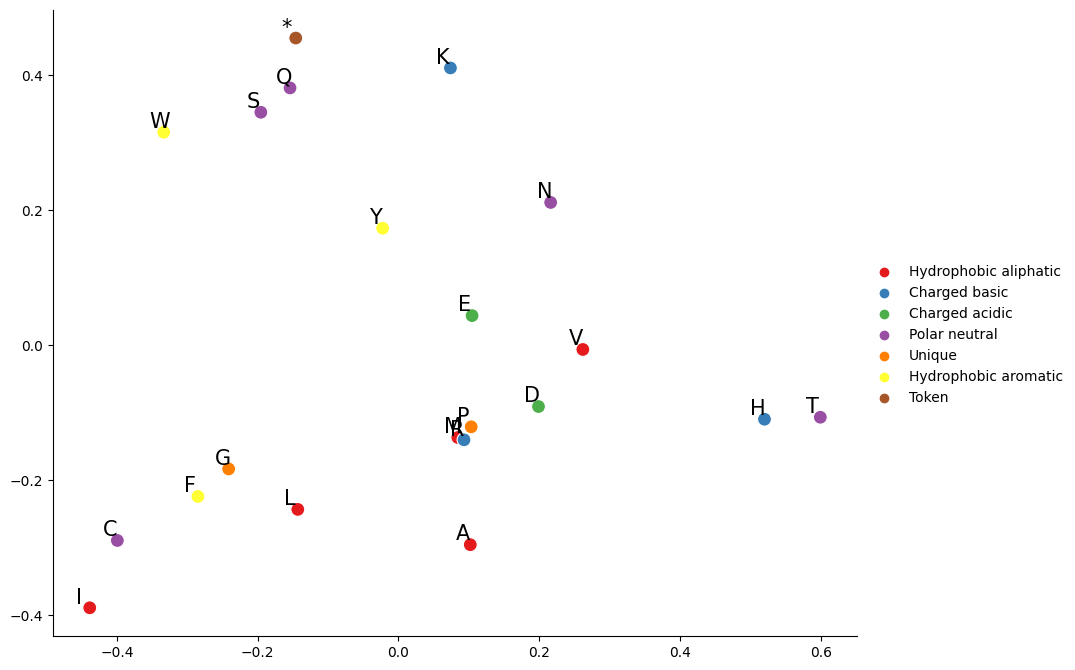

In [8]:
trainer.fit(model, train, val)

In [9]:
seq_to_restore = '<EVQLVESGPGLVQPGKSLRLSCVASGFTFSGYGMHWVRQAPGKGLEWIALIIYDESNKYYADSVKGRFTISRDNSKNTLYLQMSSLRAEDTAVFYCAKVKFYDPTAPNDYWGQGTLVTVSS>|'

In [10]:
model1 = model.ablang
tokenizer1 = model.tokenizer

with torch.no_grad():
    tokenPreds = model1(tokenizer1([seq_to_restore], pad=True, add_extra_tkns=False, device='cpu'))

tokenMAX = torch.max(torch.nn.Softmax(dim=-1)(tokenPreds), -1)

aaPreds = tokenizer1(tokenMAX[1], encode=False)

unkMatrix = torch.zeros(tokenMAX[0].shape, dtype=torch.long, device='cpu') + 21

aaPreds50 = ['-'.join(tokenizer1(torch.where(tokenMAX[0]<=.5, unkMatrix, tokenMAX[1]).detach(), encode=False)[0].split('<unk>'))]

In [11]:
tokenPreds[0][2]

tensor([-2.3041, -3.0143,  1.0899, -2.4326,  0.3744,  0.7966, -0.5975,  1.2132,
         0.6157,  1.0328,  0.1035, -2.0957,  1.5010, -0.1416,  1.0123,  4.9954,
        -0.9083,  1.2959,  0.7579,  0.6828,  2.1176, -3.9455, -2.4812, -2.7536,
        -2.9140,  0.3948])

In [12]:
tokenMAX = torch.max(torch.nn.Softmax(dim=-1)(tokenPreds), -1)
tokenMAX[1]

tensor([[ 0,  6, 15, 10, 20, 15,  6,  7, 12, 13, 12, 20, 15, 10, 13, 12,  4,  7,
         20,  2, 20,  7, 11, 15, 14,  7, 12, 17,  8, 17,  7, 12, 18, 12,  1,  7,
         19, 15,  2, 10, 14, 13, 12,  4, 12, 20,  6, 19, 20, 14, 20, 20, 20, 18,
          5,  6,  7,  9,  4, 18, 18, 14,  5,  7, 15,  4, 12,  2, 17,  8, 16,  7,
          2,  5,  9,  7,  4,  9,  8, 20,  7, 20, 10,  1,  7,  7, 20,  2, 14,  6,
          5,  8, 14, 15, 17, 18, 11, 14,  4, 15,  4, 17, 18,  5, 13,  8, 14, 13,
          9,  5, 18, 19, 12, 10, 12,  8, 20, 15,  8, 15,  7,  7, 22, 25]])

In [13]:
masked_to_restore = '***LVESGPGLVQPGKSLRLSCVASGFTFSGYGMHWVRQAPGKGLEWIALIIYDESNKYYADSVKGRFTISRDNSKNTLYLQMSSLRAEDTAVFYCAKVKFYDPTAPND************'
masked_to_restore = '<********************************GMHWVRQAPGKGLEWIALI*********ADSVKGRFTISRDNSKNTLYLQMSSLRA*********************************>|'

In [14]:
with torch.no_grad():
    tokenPreds = model1(tokenizer1([masked_to_restore], pad=True, add_extra_tkns=False, device='cpu'))
    tokenMAX = torch.max(torch.nn.Softmax(dim=-1)(tokenPreds), -1)
    masked_aaPreds = tokenizer1(tokenMAX[1], encode=False)
masked_aaPreds

['<EVQLVVVVQQVVVVPGVVLLCKVVRGGTGVGYGQYWVRQAPGKGLEPIALIQQEEVNGYYADSVVGRFTISRDTSTNTLYLQTSSLVAYYTAVFFTKKVVFYDKTKDYDDWGPDDDDVVSN>|']

In [15]:
print(aaPreds[0])
print(aaPreds50[0])
print(seq_to_restore)

<EVQLVESGPGLVQPGKSLRLSCVASGFTFSGYGMSWVRQAPGKGLEWLALLLYDESNKYYADSVKGRFTISRDNSKNTLSLQMSSLRAEDTAVFYCAKVKFYDPTAPNDYWGQGTLVTVSS>|
<EVQLV-SG-GLVQ-G-SLRLS-VASG---SG-G--WVRQA-GKGLEW-AL--YDESNKY-ADSVKGRFT-SRD-S-NTL-LQ-SSL--E-TAVFY--KVKFYD--A-NDYWGQG-LV-VSS>|
<EVQLVESGPGLVQPGKSLRLSCVASGFTFSGYGMHWVRQAPGKGLEWIALIIYDESNKYYADSVKGRFTISRDNSKNTLYLQMSSLRAEDTAVFYCAKVKFYDPTAPNDYWGQGTLVTVSS>|
